## Inspect and Clean/Preprocess Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cols = ['symboling', 'normalized_losses', 'make', 'fuel_type', 
        'aspiration', 'doors', 'body_style', 'drivetrain', 'engine-location', 
        'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type', 
        'num_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 
        'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 
        'price']

cars = pd.read_csv('imports-85.data', header=None, names=cols, na_values='?')
pd.options.display.max_columns = 50
print(cars.shape)
cars.head()

(205, 26)


,symboling,normalized_losses,make,fuel_type,aspiration,doors,body_style,drivetrain,engine-location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    164 non-null float64
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
doors                203 non-null object
body_style           205 non-null object
drivetrain           205 non-null object
engine-location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_cylinders        205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    205 non-null float64
horsepower           203 non-

In [3]:
# Replace missing values in normalized losses column with column mean

cars.loc[cars['normalized_losses'].isnull(), 'normalized_losses'] = cars.normalized_losses.mean()

In [4]:
# Drop remaining rows with n/a values and reindex

cars = cars.dropna(axis=0)
cars.reset_index(inplace=True)

In [5]:
# Remove non-numeric columns

cols_to_keep = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 
                'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 
                'highway_mpg', 'price']

cars = cars[cols_to_keep]


In [6]:
# Convert all cols to float dtype

cars = cars.astype('float')

In [7]:
# Normalize feature values from 0 to 1

predict_cols = cars.columns.tolist()
predict_cols.remove('price')

for col in predict_cols:
    cars[col] = (cars[col] - cars[col].min()) / (cars[col].max() - cars[col].min())
    

## Univariate Model

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

# Create function to test univariate models

def knn_train_test(df, feature, target_col, k=5):
    ## Input params
    # df = dataframe object
    # feature = list containing a single column name string
    # target_col = column name string to predict
    # k = number of neighbors to use
    
    np.random.seed(1)
    
    # Randomize rows
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split df into train/test
    num_rows = rand_df.shape[0]
    half = round(num_rows/2)
    train_df = rand_df.iloc[:half]
    test_df = rand_df.iloc[half:]
    
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_df[feature], train_df[target_col])
    predictions = knn.predict(test_df[feature])
    rmse = mean_squared_error(predictions, test_df[target_col])**.5
    return rmse


In [9]:
# Test univariate model on all columns using varied k values

k_values = [1, 3, 5, 7, 9]

def run_univ_model():
    rmse_scores = []
    for col in predict_cols:
        for k_val in k_values:
            rmse = knn_train_test(cars, [col], 'price', k_val)
            result = [col, k_val, round(rmse)]
            rmse_scores.append(result)
    rmse_df = pd.DataFrame(rmse_scores, columns=['Column', 'k_value', 'RMSE'])
    return rmse_df

output = run_univ_model()

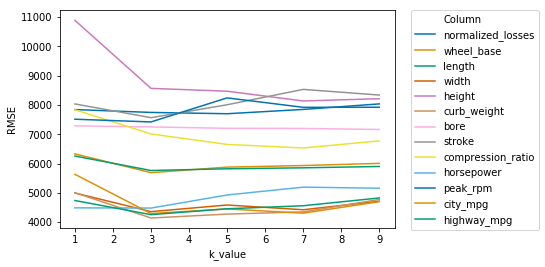

In [10]:
import seaborn as sns

sns.lineplot(data=output, x='k_value', y='RMSE', hue='Column', palette='colorblind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
# List top 5 features in order according to average rmse across k values

top_5_univ_features = output.pivot_table(index='Column', values='RMSE') \
                            .sort_values(by='RMSE').iloc[:5]

top_5_univ_features

,RMSE
Column,
curb_weight,4510.8
highway_mpg,4568.8
width,4617.2
city_mpg,4678.4
horsepower,4851.4


## Multivariate Model

In [12]:
# Test up to top 5 features from univariate model to create multivariate model

def knn_multivar(df, features, target_col, k=None):
    ## Input params
    # df = dataframe object
    # features = list containing features as strings
    # target_col = column name string to predict
    # k = number of neighbors to use
    
    np.random.seed(1)
    
    # Randomize rows
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split df into train/test
    num_rows = rand_df.shape[0]
    half = round(num_rows/2)
    train_df = rand_df.iloc[:half]
    test_df = rand_df.iloc[half:]
    
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_df[features], train_df[target_col])
    predictions = knn.predict(test_df[features])
    rmse = mean_squared_error(predictions, test_df[target_col])**.5
    return rmse

for i in range(1,6):
    val = round(knn_multivar(cars, list(top_5_univ_features.index[:i]),'price', k=5 ))
    print('Top ' + str(i) + ' Features: ' + str(val))

Top 1 Features: 4277.0
Top 2 Features: 4244.0
Top 3 Features: 3771.0
Top 4 Features: 3583.0
Top 5 Features: 3688.0


## Hyperparameter Tuning for Multivariate Model

In [13]:
final_features = top_5_univ_features.index[0:4]
tuning = []
for i in range(1,26):
    val = round(knn_multivar(cars, list(final_features), 'price', k=i))
    tuning.append([i, val])
    
k_tuning_output = pd.DataFrame(tuning, columns=['K_value', 'RMSE'])

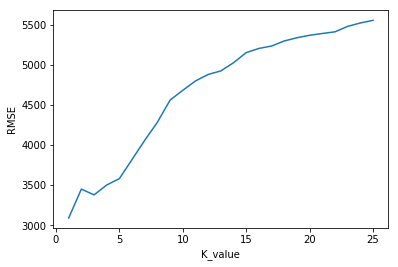

In [14]:
sns.lineplot(data=k_tuning_output, x='K_value', y='RMSE')

The multivariate model using the top 4 features with k = 1 generated the lowest RMSE thus far at 3583.0. 

## Tuning Multivariate Model using K-fold Cross Validation

In [15]:
def knn_multivar_kfold(df, features, target_col, k=None, folds=10):
    ## Input params
    # df = dataframe object
    # features = list containing features as strings
    # target_col = column name string to predict
    # k = number of neighbors to use
    # folds = number of folds to use for cross validation
    
    kf = KFold(folds, shuffle=True, random_state=2)
    knn = KNeighborsRegressor(n_neighbors=k)
    mses = cross_val_score(knn, df[features], df[target_col], scoring='neg_mean_squared_error', cv=kf)
    rmses = []
    for mse in mses:
        rmses.append(np.absolute(mse)**.5)
    
    avg_rmse = np.mean(rmses)
    return avg_rmse

knn_multivar_kfold(cars, final_features, 'price', k=2)

3042.2338750580034

## Display Cross Fold Distribution for 2-20 Folds with Hand Tuned K-value

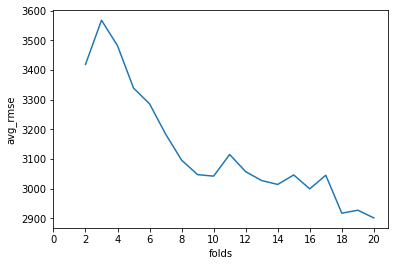

In [16]:
avg_rmses = []

for i in range(2,21):
    avg_rmse = knn_multivar_kfold(cars, final_features, 'price', k=2, folds=i)
    avg_rmses.append([i, round(avg_rmse)])
    
avg_rmses = pd.DataFrame(avg_rmses, columns=['folds', 'avg_rmse'])
sns.lineplot(data=avg_rmses, x='folds', y='avg_rmse')
ticks = plt.xticks(np.arange(0,21,2))